In [1]:

#Standard Imports
import yfinance as yf
import datetime
import numpy as np
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np

today = datetime.date.today()
yesterday = today - datetime.timedelta(days = 1)
twenty_years = 365*20
past_20 = today - datetime.timedelta(days=twenty_years)

bear_start = '1998-01-01'
bear_end = '2009-01-01'


bull_start = '2005-01-01'
bull_end = '2018-01-01'


2025-07-01 02:14:23.478937: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-01 02:14:23.664079: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-01 02:14:23.813390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751328863.933644    4933 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751328863.967285    4933 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751328864.260511    4933 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
ticker = input("Enter your ticker: ")

def gen_df(begin_year, end_year, ticker):
    #prompt user for ticker
    ticker = ticker.upper()
    df = yf.download(ticker, start = begin_year, end = end_year) 

    #Validates that a ticker has populated the DF
    while len(df) == 0:
        ticker = input("Invalid")
        ticker = ticker.upper()
        df = yf.download(ticker, start = begin_year , end = end_year) 

    #Feature engineering

    #Add features based on the Date
    df['Weekday'] = df.index.day_of_week
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['Days_Since_Start'] = (df.index - df.index[0]).days #days since start tracking
    df['Years_Since_Start'] = df['Days_Since_Start']/365
    return df

Tickerdata = gen_df(past_20,yesterday, ticker)
bear_data = gen_df(bear_start, bear_end,ticker)
bull_data = gen_df(bull_start, bull_end,ticker)

modern_avg = Tickerdata['Close'].mean()
bear_avg = bear_data['Close'].mean()
bull_avg = bull_data['Close'].mean()


scale_factor_bear = modern_avg/bear_avg
scale_factor_bull = modern_avg/bull_avg

bear_data['Close'] = scale_factor_bear * bear_data['Close']

bear_data['Open'] = scale_factor_bear * bear_data['Open']

bull_data['Open'] = scale_factor_bull * bull_data['Open']
bull_data['Close'] = scale_factor_bull * bull_data['Close']


def engineer_features(df):
    df['Log_Close'] = np.log(df['Close'])
    df['SMA_30'] = df['Close'].rolling(window = 30).mean()
    df['SMA_200'] = df['Close'].rolling(window = 200).mean() #200 day moving average using the rolling function, will create NANS that we will drop
    df['SMA_500'] = df['Close'].rolling(window = 500).mean()
    df['volatility'] = df['Close'].rolling(window=200).std()
    return df

Tickerdata = engineer_features(Tickerdata)
bear_data = engineer_features(bear_data)
bull_data = engineer_features(bull_data)
def add_fourier_terms(df, period=252, ): #adding 4 terms helped create a good shape for the LSTM, orginally only wanted sin, cos of 1, 2, and 4, but adding three helped smooth final DF generated out
    t = np.arange(len(df))
    df['sin_1'] = np.sin(2 * np.pi * 1 * t / period) 
    df['cos_1'] = np.cos(2 * np.pi * 1 * t / period)
    df['sin_2'] = np.sin(2 * np.pi * 2 * t / period) 
    df['cos_2'] = np.cos(2 * np.pi * 2 * t / period)
    df['sin_3'] = np.sin(2 * np.pi * 2 * t / period) 
    df['cos_3'] = np.cos(2 * np.pi * 2 * t / period)
    df['sin_4'] = np.sin(2 * np.pi * 4 * t / period) 
    df['cos_4'] = np.cos(2 * np.pi * 4 * t / period)
    return df

Tickerdata = add_fourier_terms(Tickerdata)
bear_data = add_fourier_terms(bear_data)
bull_data = add_fourier_terms(bull_data)

Tickerdata.dropna(inplace=True)
bear_data.dropna(inplace=True)
bull_data.dropna(inplace=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Fourier Terms

t - time index(days since start)
period - one trading year
i-number of waves 1st,2nd,3rd | Changes the frequency of the sine and cosine waves, 1 wave (252 days one full trading year), 2 waves(semmi annual) 4 waves(Quarterly)

This will help during forecasting dating rather than model training, as it will give a shape to the data that is more fit to the seasons


### EXAMPLE WITHOUT FOURIER TERMS ON AAPL Forecast
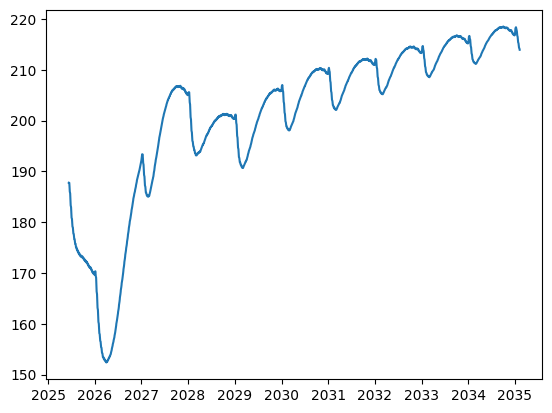
Only observable seasonality is annual, roughly same shape repeated every year with little variation


### Example WITH FOURIER TERMS ON AAPL FORECAST
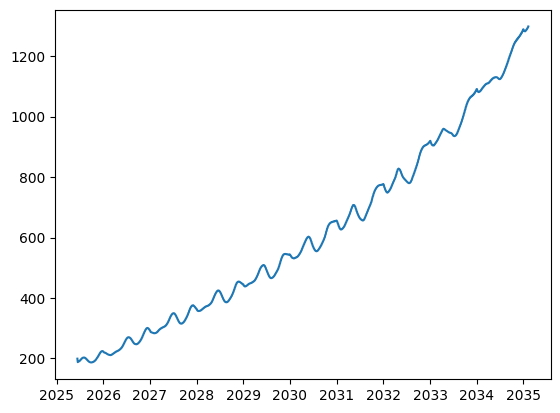

Data varies throughout the year less repetitive,  differences in shape every year

In [17]:
#Simple Linear Regression Model That will establish a stable long term trend
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score,mean_absolute_percentage_error



linx = Tickerdata[['Years_Since_Start']]
liny = Tickerdata['Log_Close']

linx_train,linx_test, liny_train,liny_test = train_test_split(linx, liny, test_size= .2, shuffle=False) #do not shuffle for time series data
linreg_model = LinearRegression().fit(linx_train, liny_train)
log_test = linreg_model.predict(linx_test)
price_pred = np.exp(log_test)

print("lin model R2: ", r2_score(np.exp(liny_test), price_pred ))

rmse = root_mean_squared_error(np.exp(liny_test), price_pred)
print("RMSE:", rmse)
mape = mean_absolute_percentage_error(np.exp(liny_test), price_pred)
print("MAPE: ",mape*100,"%")


year = Tickerdata['Years_Since_Start'].iloc[-1]

Decade = np.array([[year+10]])

future_log = linreg_model.predict(Decade)

future_price = np.exp(future_log)[0]

print('Future Price Predicted: ',future_price)

current_price = Tickerdata['Close'].iloc[-1][0]

CAGR = (future_price/current_price)**(1/10)  - 1

print('Compound Annual Growth Rate: ', CAGR)

lin model R2:  0.6684919102611718
RMSE: 44.736374378810225
MAPE:  7.70297873284826 %
Future Price Predicted:  1734.376581261705
Compound Annual Growth Rate:  0.10925957552256627


/tmp/ipykernel_4933/1921611997.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price = Tickerdata['Close'].iloc[-1][0]



    short_term_features = ['Weekday', 'Month', 'Open', "Years_Since_Start", "Days_Since_Start", "SMA_200", "SMA_500",'sin_1', 'sin_2','sin_3' ,'sin_4', 'cos_1', 'cos_2','cos_3', 'cos_4']
    x = Tickerdata[short_term_features]
    y = Tickerdata['Log_Close'].values.reshape(-1, 1) 

    from sklearn.preprocessing import StandardScaler
    xscaler = StandardScaler()
    yscaler = StandardScaler()
    xscale= xscaler.fit_transform(x)
    yscale = yscaler.fit_transform(y)

    window = int(len(Tickerdata)/2) #Need a large window size, this will improve model performance


    def train_lstm(x, y, window):
        x_lstm, y_lstm = [], []
        for i in range(window, len(x)):
            x_lstm.append(x[i-window:i])
            y_lstm.append(y[i]) 
            # creates window sized chunks ,overlapping one day at a time until the last day of the dataframe for x to predict the end window sized chunk of y
        return np.array(x_lstm), np.array(y_lstm)
    x_lstm, y_lstm = train_lstm(xscale, yscale, window)

    x_train,x_test,y_train,y_test = train_test_split(x_lstm, y_lstm, test_size=.2, shuffle=False)


    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(128, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2]))) 
    #model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.LSTM(128, return_sequences=True )) 
    #model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.LSTM(128, return_sequences=False )) 
    #model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mean_absolute_percentage_error'])
    model.summary()



In [18]:
def train_model_main(df):
    
    import tensorflow as tf
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error
    import matplotlib.pyplot as plt
    import numpy as np



    short_term_features = ['Weekday', 'Month', 'Open', "Years_Since_Start", "Days_Since_Start", "SMA_200", "SMA_500",'sin_1', 'sin_2','sin_3' ,'sin_4', 'cos_1', 'cos_2','cos_3', 'cos_4']
    x = df[short_term_features]
    y = df['Log_Close'].values.reshape(-1, 1) 
    

    xscaler = StandardScaler()
    yscaler = StandardScaler()
    xscale= xscaler.fit_transform(x)
    yscale = yscaler.fit_transform(y)

    window = int(len(df)/1/2)#Need a large window size, this will improve model performance


    def train_lstm(x, y, window):
        x_lstm, y_lstm = [], []
        for i in range(window, len(x)):
            x_lstm.append(x[i-window:i])
            y_lstm.append(y[i]) 
            # creates window sized chunks ,overlapping one day at a time until the last day of the dataframe for x to predict the end window sized chunk of y
        return np.array(x_lstm), np.array(y_lstm)
    x_lstm, y_lstm = train_lstm(xscale, yscale, window)

    x_train,x_test,y_train,y_test = train_test_split(x_lstm, y_lstm, test_size=.2, shuffle=False)


    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(128, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2]))) 
    model.add(keras.layers.LSTM(128, return_sequences=True))
    model.add(keras.layers.LSTM(128, return_sequences=False))                      
    model.add(keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mean_absolute_percentage_error'])
    model.summary()


    hist = model.fit(x_train, y_train, epochs=30, batch_size=64, validation_split=.3, verbose=1 ,callbacks =
                
    [tf.keras.callbacks.EarlyStopping(
    monitor = 'val_mean_absolute_percentage_error', mode = 'min',
    patience = 16,
    restore_best_weights = True
    )])
    model.summary()
    
    y_pred = model.predict(x_test)
    y_pred_real = yscaler.inverse_transform(y_pred)
    y_test_real = yscaler.inverse_transform(y_test.reshape(-1, 1))
    
    fig, ax = plt.subplots()
    ax.plot(np.exp(y_test_real), label='Actual')
    ax.plot(np.exp(y_pred_real), label='Predicted')

    ax.set_title("Main Model - LSTM: Actual vs Predicted Prices")
    ax.set_xlabel('Trading Days in Training Set')
    ax.set_ylabel('close price')
    ax.legend()
    #plt.show()
    
    LSTM_rmse = root_mean_squared_error(np.exp(y_test_real),np.exp(y_pred_real))
    LSTM_r2 = r2_score(np.exp(y_test_real),np.exp(y_pred_real))
    LSTM_mape = mean_absolute_percentage_error(np.exp(y_test_real),np.exp(y_pred_real))

    summary = {'RMSE':LSTM_rmse,
               'R2':LSTM_r2,
               'MAPE':LSTM_mape}

    return model, fig, summary, xscaler, yscaler, xscale



In [19]:
def train_model_bear(df,xscaler, yscaler):
    
    import tensorflow as tf
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error
    import matplotlib.pyplot as plt
    import numpy as np



    short_term_features = ['Weekday', 'Month', 'Open', "Years_Since_Start", "Days_Since_Start", "SMA_200", "SMA_500",'sin_1', 'sin_2','sin_3' ,'sin_4', 'cos_1', 'cos_2','cos_3', 'cos_4']
    x = df[short_term_features]
    y = df['Log_Close'].values.reshape(-1, 1) 
    

    xscale= xscaler.transform(x)
    yscale= yscaler.transform(y)

    window = int(len(df)/1/4)#Need a large window size, this will improve model performance


    def train_lstm(x, y, window):
        x_lstm, y_lstm = [], []
        for i in range(window, len(x)):
            x_lstm.append(x[i-window:i])
            y_lstm.append(y[i]) 
            # creates window sized chunks ,overlapping one day at a time until the last day of the dataframe for x to predict the end window sized chunk of y
        return np.array(x_lstm), np.array(y_lstm)
    x_lstm, y_lstm = train_lstm(xscale, yscale, window)

    x_train,x_test,y_train,y_test = train_test_split(x_lstm, y_lstm, test_size=.2, shuffle=False)


    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(256, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2]))) 
    model.add(keras.layers.LSTM(256, return_sequences=False )) 

    model.add(keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mean_absolute_percentage_error'])
    model.summary()

    hist = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=.3, verbose=1 ,callbacks =
                
    [tf.keras.callbacks.EarlyStopping(
    monitor = 'val_mean_absolute_percentage_error', mode = 'min',
    patience = 5,
    restore_best_weights = True
    )])
    
    y_pred = model.predict(x_test)
    y_pred_real = yscaler.inverse_transform(y_pred)
    y_test_real = yscaler.inverse_transform(y_test.reshape(-1, 1))
    
    fig, ax = plt.subplots()
    ax.plot(np.exp(y_test_real), label='Actual')
    ax.plot(np.exp(y_pred_real), label='Predicted')

    ax.set_title("Bear Model Forecast - LSTM: Actual vs Predicted Prices")
    ax.set_xlabel('Trading Days in Training Set')
    ax.set_ylabel('close price')
    ax.legend()
    plt.show()
    
    LSTM_rmse = root_mean_squared_error(np.exp(y_test_real),np.exp(y_pred_real))
    LSTM_r2 = r2_score(np.exp(y_test_real),np.exp(y_pred_real))
    LSTM_mape = mean_absolute_percentage_error(np.exp(y_test_real),np.exp(y_pred_real))
    

    summary = {'RMSE':LSTM_rmse,
               'R2':LSTM_r2,
               'MAPE':LSTM_mape}

    return model, fig, summary, xscaler, yscaler



In [20]:
def train_model_bull(df, xscaler, yscaler):
    
    import tensorflow as tf
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error
    import matplotlib.pyplot as plt
    import numpy as np



    short_term_features = ['Weekday', 'Month', 'Open', "Years_Since_Start", "Days_Since_Start", "SMA_200", "SMA_500",'sin_1', 'sin_2','sin_3' ,'sin_4', 'cos_1', 'cos_2','cos_3', 'cos_4']
    x = df[short_term_features]
    y = df['Log_Close'].values.reshape(-1, 1) 
    


    xscale= xscaler.transform(x)
    yscale = yscaler.transform(y)

    window = int(len(df)/1/2)#Need a large window size, this will improve model performance


    def train_lstm(x, y, window):
        x_lstm, y_lstm = [], []
        for i in range(window, len(x)):
            x_lstm.append(x[i-window:i])
            y_lstm.append(y[i]) 
            # creates window sized chunks ,overlapping one day at a time until the last day of the dataframe for x to predict the end window sized chunk of y
        return np.array(x_lstm), np.array(y_lstm)
    x_lstm, y_lstm = train_lstm(xscale, yscale, window)

    x_train,x_test,y_train,y_test = train_test_split(x_lstm, y_lstm, test_size=.4, shuffle=False)


    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(256, return_sequences=False, input_shape=(x_train.shape[1],x_train.shape[2]))) 
    #model.add(keras.layers.Dropout(.5))


    #model.add(keras.layers.LSTM(8, return_sequences=False))

                                
    model.add(keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mean_absolute_percentage_error'])
    model.summary()


    hist = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=.3, verbose=1 ,callbacks =
                
    [tf.keras.callbacks.EarlyStopping(
    monitor = 'val_mean_absolute_percentage_error', mode = 'min',
    patience = 5,
    restore_best_weights = True
    )])
    model.summary()
    
    y_pred = model.predict(x_test)
    y_pred_real = yscaler.inverse_transform(y_pred)
    y_test_real = yscaler.inverse_transform(y_test.reshape(-1, 1))
    
    fig, ax = plt.subplots()
    ax.plot(np.exp(y_test_real), label='Actual')
    ax.plot(np.exp(y_pred_real), label='Predicted')

    ax.set_title("Bull Model - LSTM: Actual vs Predicted Prices")
    ax.set_xlabel('Trading Days in Training Set')
    ax.set_ylabel('close price')
    ax.legend()
    #plt.show()
    
    LSTM_rmse = root_mean_squared_error(np.exp(y_test_real),np.exp(y_pred_real))
    LSTM_r2 = r2_score(np.exp(y_test_real),np.exp(y_pred_real))
    LSTM_mape = mean_absolute_percentage_error(np.exp(y_test_real),np.exp(y_pred_real))

    summary = {'RMSE':LSTM_rmse,
               'R2':LSTM_r2,
               'MAPE':LSTM_mape}

    return model, fig, summary, xscaler, yscaler



/home/eduard/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 2264, 128)      │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 2264, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 337,025 (1.29 MB)

 Trainable params: 337,025 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - loss: 0.0765 - mean_absolute_percentage_error: 67.0482 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 9.8106
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - loss: 0.0082 - mean_absolute_percentage_error: 42.7079 - val_loss: 0.0143 - val_mean_absolute_percentage_error: 8.6805
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - loss: 0.0037 - mean_absolute_percentage_error: 21.4646 - val_loss: 0.0240 - val_mean_absolute_percentage_error: 11.8005
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - loss: 0.0025 - mean_absolute_percentage_error: 17.2615 - val_loss: 0.0189 - val_mean_absolute_percentage_error: 10.5615
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - loss: 0.0026 - mean_absolute_percentage_error: 17.8997 - val_loss: 0.0075 - val_mean_absolute_percentage_error: 6.2875
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - loss: 0.0026 - mean_absolute_percentage_error: 18.0389 - val_loss: 0.0094 - val_mean_absolu

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 2264, 128)      │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 2264, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,011,077 (3.86 MB)

 Trainable params: 337,025 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 674,052 (2.57 MB)

15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 699ms/step


/home/eduard/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 256)            │       278,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 278,785 (1.06 MB)

 Trainable params: 278,785 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.1700 - mean_absolute_percentage_error: 191.3927 - val_loss: 0.0094 - val_mean_absolute_percentage_error: 11.3596
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 0.0301 - mean_absolute_percentage_error: 289.9080 - val_loss: 0.0211 - val_mean_absolute_percentage_error: 15.8030
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 0.0158 - mean_absolute_percentage_error: 79.9678 - val_loss: 0.0391 - val_mean_absolute_percentage_error: 22.1123
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 0.0061 - mean_absolute_percentage_error: 40.2985 - val_loss: 0.0441 - val_mean_absolute_percentage_error: 26.5697
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 0.0062 - mean_absolute_percentage_error: 70.4177 - val_loss: 0.0111 - val_mean_absolute_percentage_error: 11.3315
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 0.0035 - mean_absolute_percentage_error: 75.0983 - val_loss: 0.0095 - val_mean_absolute_perc

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 256)            │       278,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 836,357 (3.19 MB)

 Trainable params: 278,785 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 557,572 (2.13 MB)

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step


/home/eduard/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 567, 256)       │       278,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 804,097 (3.07 MB)

 Trainable params: 804,097 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.0916 - mean_absolute_percentage_error: 282.7738 - val_loss: 0.0897 - val_mean_absolute_percentage_error: 58.8208
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0160 - mean_absolute_percentage_error: 145.0046 - val_loss: 0.0079 - val_mean_absolute_percentage_error: 14.7549
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.0058 - mean_absolute_percentage_error: 104.4256 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 12.1823
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.0024 - mean_absolute_percentage_error: 60.6933 - val_loss: 0.0029 - val_mean_absolute_percentage_error: 8.2014
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.0015 - mean_absolute_percentage_error: 51.2553 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 11.9151
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.0021 - mean_absolute_percentage_error: 45.4169 - val_loss: 0.0060 - val_mean_a

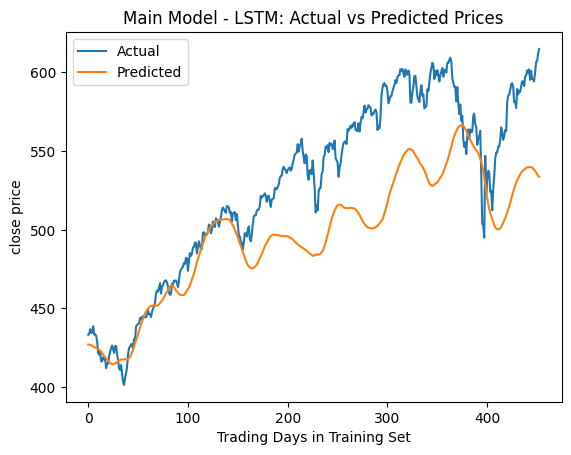

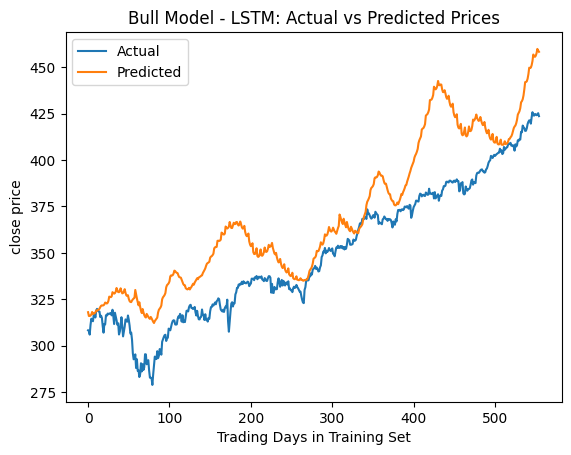

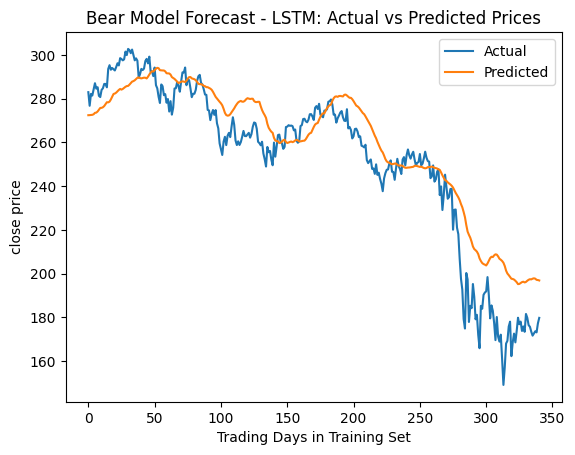

In [21]:
model, main_fig, main_summary, xscaler, yscaler,xscale = train_model_main(Tickerdata)

bull_model, bull_fig, bull_summary, bull_xscaler, bull_yscaler = train_model_bull(bull_data,xscaler,yscaler)

bear_model,bear_fig,bear_summary, bear_xscaler, bear_yscaler = train_model_bear(bear_data, xscaler, yscaler)


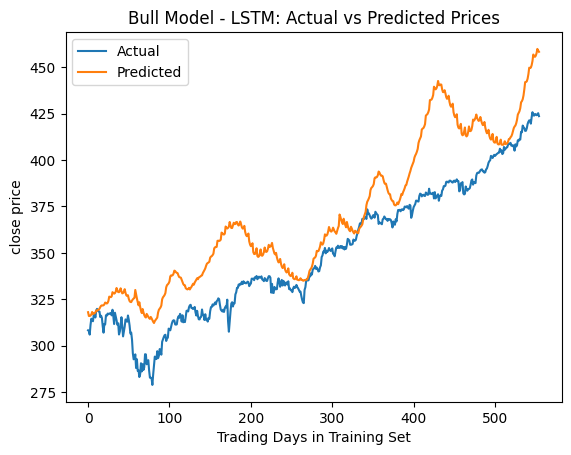

In [22]:
bull_fig


In [23]:
print(bull_summary)

{'RMSE': 24.312368123632424, 'R2': 0.5471558592970731, 'MAPE': 0.05849006486278931}


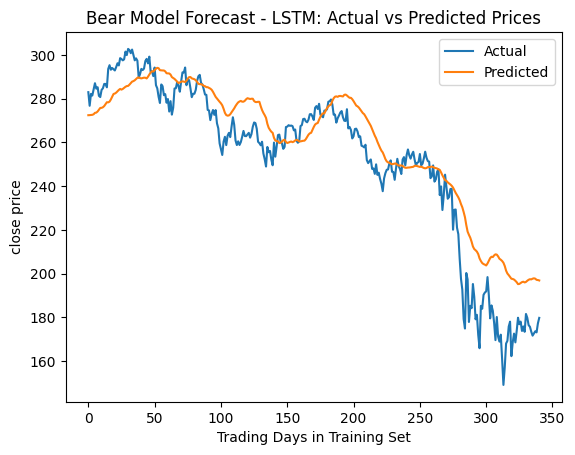

In [24]:
bear_fig


In [25]:
print(bear_summary)

{'RMSE': 15.39274589452926, 'R2': 0.8383453867955241, 'MAPE': 0.054323330656324734}


In [ ]:
import joblib

bull_model.save('bull-SPY.keras')
bear_model.save('bear-SPY.keras')
model.save('main-SPY.keras')

joblib.dump(xscaler, 'spy-xscaler.pkl')
joblib.dump(yscaler,'spy-yscaler.pkl')
joblib.dump(xscale, 'spy-xscale.pkl')
joblib.dump(Tickerdata, 'spy-tickerdata.pkl')

['spy-xscale.pkl']

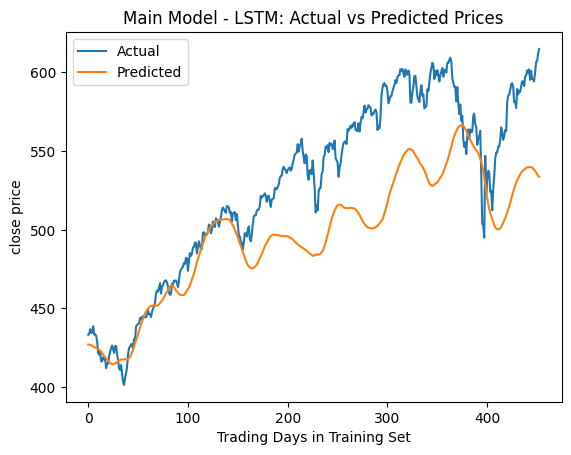

In [27]:
main_fig

In [28]:
main_summary

{'RMSE': 41.06552060665669,
 'R2': 0.4821836599837902,
 'MAPE': 0.058533331874727146}

### Setting a Trend 

We need to set a trend for our forecast, if we do not do that our forecasted data will hover around the same prices (the more recent prices collected during the window, which is why we also set a very wide window during the train-test-split). We are going to set a trend based on the Compound Annual Growth Rate (CAGR) of our ticker for the past 5 years of its history, this way the trend can be organic to each ticker.

For the Code below, we are attempting to create a loop that will forecast the price of our ticker 10 years into the future using the predict method. We will need to first feed it recent values, since our SMA_500 requires the largest amount of data, we will give it a dataset of the past 500 days. Forecasting features will be the same as our prediction features (reason I have two different variables is because I at one point experimented with trying different feature sets for forecasting and model training). 

Our forecast loop will need to loop over 2520 TRADING DAYS, so we will need to add a feature to skip weekends, reshape our data into an array again to feed into our LSTM predictor (just like we did above) 

In [ ]:
def forecast(df, model, xscaler, yscaler,xscale):    
    
    from datetime import timedelta
    import numpy as np



    #Need a recent CAGR For our Forecasting Trend:
    lookback_days = 1260 
    recent_data = Tickerdata.iloc[-lookback_days:]

    start_price = recent_data['Close'].iloc[-400]
    end_price = recent_data['Close'].iloc[-1]
    years = (recent_data.index[-1] - recent_data.index[0]).days / 365

    cagr = (end_price / start_price) ** (1 / years) - 1
    log_cagr = np.log(1 + cagr)

    #We need a list of opening prices that our forecasting will work on

    pricehist = df['Open'].iloc[:,0]
    pricehist = pricehist.iloc[-500:]
    pricehist = pd.Series(pricehist)
    pricehist = list(pricehist)

    forecast_features = [
                        'Weekday', 'Month', 'Open', "Years_Since_Start", "Days_Since_Start", "SMA_200", "SMA_500", 'sin_1', 'sin_2','sin_3', 'sin_4', 'cos_1', 'cos_2','cos_3', 'cos_4'
        ]


    window = 252
    forecast_days = 2520

    #use some of our old data
    feature_hist = xscale[-window:] 

    last_day_count = df['Days_Since_Start'].iloc[-1]
    total_years = df['Years_Since_Start'].iloc[-1]
    date = df.index[-1]
    SMA_200 = np.mean(pricehist[-200:])
    SMA_500=  np.mean(pricehist[-500:])


    future_dates = []

    pred_log = []
    pred_price = []


    #create a daily trend variable to add a trend to the data 



    for i in range(forecast_days):
        t = len(Tickerdata) + i + 1

        #NEED this if statement, otherwise our first day dramatically trends downward on the first forecasted day, we will just append the last close price & not do anything else
        if i == 0:
            date += timedelta(days=1)
            while date.weekday() > 4:
                date += timedelta(days=1)

            log_scaled = model.predict(feature_hist.reshape(1, window, -1))[0, 0]
            log_real = yscaler.inverse_transform([[log_scaled]])[0, 0]

            # Blend log prediction with real last log price (weighted average)
            last_log = np.log(df['Close'].iloc[-1])
            log_real_blend = 0.7 * last_log + 0.3 * log_real  # adjust blend as needed

            log_real_trend = log_real_blend  # no CAGR yet
            pred_log.append(log_real_blend)
            pred_price.append(np.exp(log_real_trend))
            future_dates.append(date)
            continue

        #skip non trading days
        date += timedelta(days=1)
        while date.weekday() > 4:
            date += timedelta(days=1) 

        #pricehist = Tickerdata['Open'].iloc[-500:]
        # Reshape our data for LSTM
        LSTM_input = feature_hist.reshape(1, window, -1)
        #Predict on our databull_model
        log_scaled = model.predict(LSTM_input)[0, 0]


        #transform our target
        log_real = yscaler.inverse_transform([[log_scaled]])[0, 0]

        #adding our CAGR Trend
        log_real_trend = log_real + log_cagr * i / 252
        pred_log.append(log_real)


        #exponentiate to list of predictions in dollars


        #####################################################
        price = float(np.exp(log_real_trend))#cast to float to avoid error
       # price = float(np.exp(log_real))
        pred_price.append(price)
        pricehist.append(price)
        pricehist = pricehist[-500:]

        #redefine these features to be used meaningfully inside our loop
        SMA_200 = np.mean(pricehist[-200:])
        SMA_500=  np.mean(pricehist[-500:])
        #volatility = np.std(pricehist[-200:])
        #append next trading day to 
        future_dates.append(date) 

        #Generate next row using predicted price as Open
        year = total_years + (i+1) / 252
        new_row = {
            'Weekday':date.weekday(),
            'Month': date.month,
            'Open': price,
            'Year': date.year,
            'Years_Since_Start': year,
            'Days_Since_Start': last_day_count + i + 1,   
            'SMA_200':SMA_200,
            'SMA_500':SMA_500,
        }


        new_row['sin_1'] = np.sin(2*np.pi* 1 * t / 252)
        new_row['cos_1'] = np.cos(2*np.pi* 1 * t / 252)   

        new_row['sin_2'] = np.sin(2*np.pi* 2 * t / 252)
        new_row['cos_2'] = np.cos(2*np.pi* 2 * t / 252)

        new_row['sin_3'] = np.sin(2*np.pi* 4 * t / 252)
        new_row['cos_3'] = np.cos(2*np.pi* 4 * t / 252)

        new_row['sin_4'] = np.sin(2*np.pi* 4 * t / 252)
        new_row['cos_4'] = np.cos(2*np.pi* 4 * t / 252)




        #create array of features
        new_vals = np.array([[new_row[feat] for feat in forecast_features]])
        #scale the new vals
        new_scaled = xscaler.transform(new_vals)

        #  Update window
        feature_hist = np.vstack([feature_hist, new_scaled])[-window:]
    

    forecast_df = pd.DataFrame({
        'Date':future_dates,
        'Log_Close_Pred': pred_log,
        'Close_Pred': pred_price
    }).set_index('Date')

    return forecast_df


In [30]:
forecast_df_main = forecast(Tickerdata, model, xscaler,yscaler,xscale)

forecast_bear = forecast(Tickerdata, bear_model, xscaler, yscaler, xscale)

forecast_bull = forecast(Tickerdata, bull_model, xscaler, yscaler, xscale)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid er

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error
/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipykernel_4933/3976114420.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(np.exp(log_real_trend))#cast to float to avoid error


KeyboardInterrupt: 

In [ ]:
plt.plot(forecast_df_main['Close_Pred'])
plt.show()


In [ ]:
plt.plot(forecast_bear['Close_Pred'])
plt.show()

In [ ]:
plt.plot(forecast_bull['Close_Pred'])
plt.show()

In [ ]:
forecast_bear

In [ ]:
forecast_df_main['Close_Pred'][-1]

In [ ]:
bear_data['Close'].mean()

In [ ]:
Tickerdata['Close'].mean()